In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from logistics import new_cav_model , J_analytical_new, fourier_transform_matrix, fast_f_t, spectrum_1
from logistics_exact_cavity import Driven_cavity_class,two_modes_cavity
from numpy.fft import fft,fftfreq
from scipy.interpolate import interp1d	

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.size'] = 14  


Voy a hacer un plot que enseñe que, en el limite markoviano, puedo explicar lo que veo con una cavidad y su free spectral range. Para ello, defino el error 
$$ \epsilon(N_{modes},\gamma \tau) = \frac{1}{t_{max}} \int_{0}^{t_{max}} \sqrt{\rho^{2}_{ee}(u)-\rho^{2}_{ee,N_{modes},\gamma \tau}(u)} du $$
Y lo ploteo como funcion del numero de modos y de $\gamma \tau$. La idea es que se vea que necesitas mas modos a medida que $\gamma \tau$ crece, pero que llegado un punto el erorr empieza a oscilar porque abandonas markovianidad. Solo miro el excited state, lo cual es un poco biased, pero bueno 

No se si tiene mas sentido hacer error sobre las fft. Parece mas sencillo, pero como no se que hace por dentro la fft tengo una caja negra ahí. Pero vaya que 
Voy a hacer un loop con todo y puedo quedarme con la fft y medir el error tambn

In [169]:
from dataclasses import dataclass, field
from scipy.linalg import expm

def mkron(A, *args):
	if len(args) == 0:
		return A
	return np.kron(A, mkron(args[0], *args[1:]))

def b_op(i: int, n: int) -> np.ndarray:
	''' generator of sigma^{-}_{i} operators in the initial state (standard pauli matrices times the identity)'''
	return mkron(np.eye(2**i), [[0, 0], [1, 0]], np.eye(2 ** (n - i - 1))).astype(np.complex128)

@dataclass
class Nmode_cavity:
	omega_qubit :float  = 1 
	coupling: float = 1 
	modes_frequencies:np.ndarray = field(default_factory=lambda: np.array([]))
	Hamiltonian: np.ndarray = field(init=False) 
	psi0: np.ndarray = field(init=False) 
	
	def __post_init__(self):
		N = len(self.modes_frequencies)
		self.Hamiltonian = np.zeros((N+1,N+1),dtype=complex)
		self.Hamiltonian[0,0] = self.omega_qubit
		for n in range(N):
			self.Hamiltonian[n+1,n+1] = self.modes_frequencies[n]
			self.Hamiltonian[n+1,0] = self.coupling
			self.Hamiltonian[0,n+1] = self.coupling
		self.psi0 = np.zeros(len(self.modes_frequencies)+1,dtype=complex)
		self.psi0[0] = 1
	def evolve(self,times):
		vec=[] 
		for t in times:
			U = expm(-1j*self.Hamiltonian*t)
			vec.append(U@self.psi0)
		return np.asarray(vec)
		
		
def FRS(N,tau):
    return  np.arange(-2*(N-1),2*(N+1),2)*np.pi/tau 

def err_est(t,y1,y2): 
    t = np.asarray(t)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    integrand = np.sqrt(np.abs(y1**2 - y2**2))
    integral = np.trapezoid(integrand, t)
    t_max = t[-1] - t[0]

    return integral / t_max

In [117]:
gamma = 1
tau = 0.2 
phi = 1.5*np.pi 
t_max = 100*tau
dt = tau/50

In [118]:
cavity = new_cav_model(gamma,phi,tau,0)
cavity.evolve(t_max,dt)
t,e = cavity.excited_state([1,0])

In [204]:
error_list = []
for n in range(1,15):
    exact = Nmode_cavity(phi/tau,np.sqrt(gamma/tau),FRS(n,tau))
    pe=np.abs(exact.evolve(t)[:,0]**2)
    error_list.append(err_est(t,e,pe))



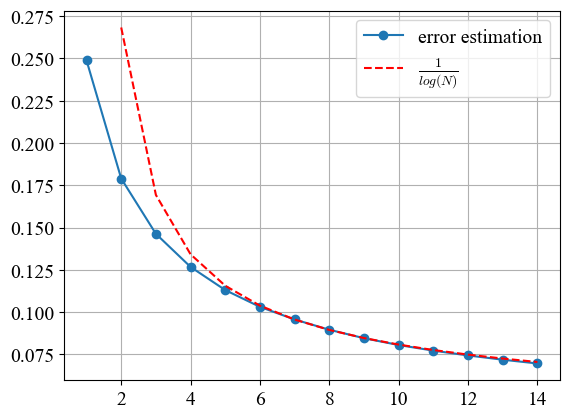

In [207]:
plt.plot(np.arange(1,15),error_list,'-o',label='error estimation')
plt.plot(np.arange(2,15),0.186/np.log(np.arange(2,15)),'r--',label =r"$\frac{1}{log(N)}$")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def exp000(phi,gamma,tau_values):
	t_list=[]
	pe_list = []
	fft_i=[]
	fft_a =[]
	freqs=[]

	for tau in tau_values:
		dt = tau/60 
		t_max=125*tau
		cavity=new_cav_model(gamma,phi,tau,0)
		cavity.evolve(t_max,dt)
		t,e = cavity.excited_state([1,0])
		t_list.append(t)
		pe_list.append(e)
		
		_,I = cavity.current([1,0])
		_,ffti=fast_f_t(t[t/tau>10],I[t/tau>10],400)   # looking at the stable current 
		fft_i.append(ffti)
		
		a_out=cavity.a_out_array
		w,aw =fourier_transform_matrix(t,a_out,400)
		spec = spectrum_1(aw,[1,0])
		freqs.append(w)
		fft_a.append(spec)
	return t_list,pe_list,fft_i,fft_a,freqs

In [40]:
phi = 2*np.pi 
gamma = 1 
tau_values = np.arange(0.1,3.25,0.05)

t_list,pe_list,fft_i,fft_a,freqs = exp000(phi,gamma,tau_values)

In [ ]:
max_freq = []
for n in range(len(fft_a)):
	spec = fft_a[n]
	freq = freqs[n]
	max_freq.append(freq[np.argmax(np.abs(spec))])

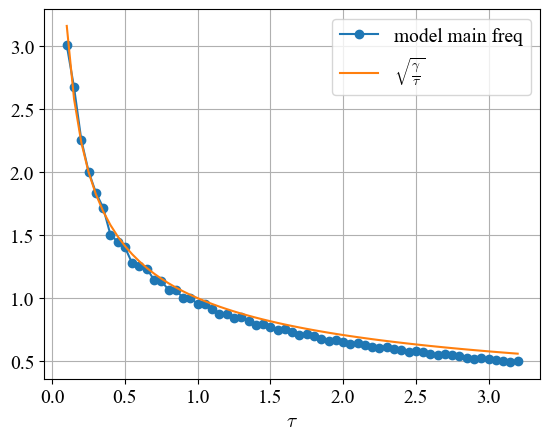

In [42]:
plt.plot(tau_values, max_freq,'-o',label='model main freq')
plt.plot(tau_values,np.sqrt(gamma/tau_values),label=r"$\sqrt{\frac{\gamma}{\tau}}$")
plt.xlabel(r"$ \tau$ ")
plt.legend()
plt.grid()
plt.show()

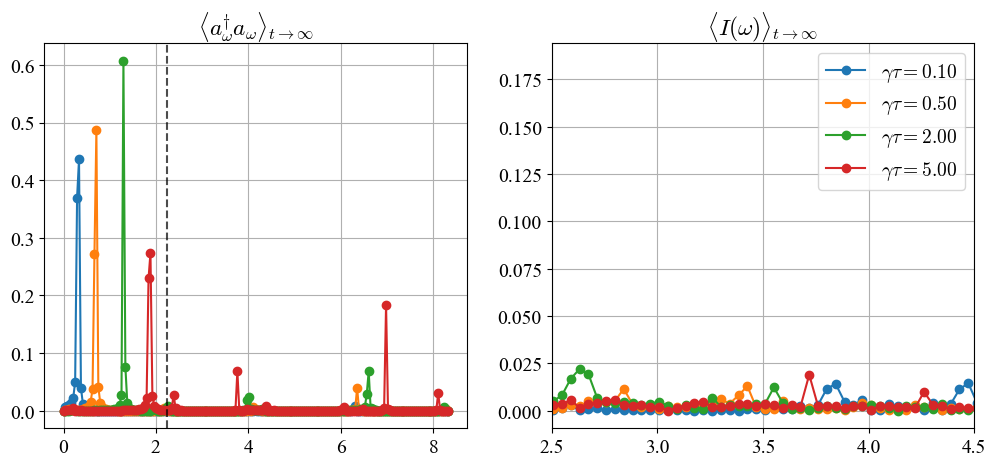

In [ ]:
fig,axs = plt.subplots(1,2,figsize = (12,5))

for n in range(len(tau_values)):
	axs[0].plot(freqs[n]*tau_values[n],np.abs(fft_a[n])/np.sum(np.abs(fft_a[n])),'-o')
	axs[1].plot(freqs[n]*tau_values[n],np.abs(fft_i[n]),'-o',label = rf"$\gamma \tau = {gamma*tau_values[n]:.2f}$")

m=3
#w_ref = np.sqrt(np.pi**2+2*gamma*tau_values[m])
w_ref = np.sqrt(gamma*tau_values[m])

axs[0].grid()
axs[0].set_title(r"$\langle a_{\omega}^{\dag}a_{\omega}\rangle_{t\to \infty} $")
#axs[0].set_xlim(2.5,4.5)
axs[0].axvline(w_ref,linestyle='--',color='k',alpha=0.7)

axs[1].grid()
axs[1].set_title(r"$\langle I(\omega)\rangle_{t\to \infty} $")
axs[1].legend()
axs[1].set_xlim(2.5,4.5)
axs[1].axvline(w_ref,linestyle='--',color='k',alpha=0.7)


plt.show()
